In [ ]:
import time
import math
import torch
import matplotlib.pyplot as plt
import SQ_LASSO

dtype = torch.float
device_id = "cuda"

In [2]:
def generate_data(N, M, D, dtype=torch.double, device="cuda"):
    # sample D-dimensional array of random Tchebychev points in [-1,1]^D
    samples = math.pi * (
        torch.rand(N, D, dtype=dtype, device=device, requires_grad=False) - 0.5
    )
    samples = samples.tan()
    samples = samples / torch.sqrt(samples**2 + 1)

    # define D-dimensional array of indices in [0, R]^D based on hyperbolic cross density
    def hyp_cross(dim, R):
        if dim == 1:
            return [[k] for k in range(0, R + 1)]
        out = []
        for kk in hyp_cross(dim - 1, R):
            prod_val = 1
            for x in kk:
                prod_val *= max([1, abs(x)])
            rk = R // prod_val
            for r in range(0, rk + 1):
                out.append(kk + [r])
        return out

    # create hyperbolic cross indices
    indices = torch.round(
        torch.FloatTensor(hyp_cross(D, M)).to(dtype=torch.double, device=device)
    )
    indices.requires_grad = False

    # function in H^3/2 with known Fourier coefficients
    def fun2(x):
        neg_mask = x <= 0
        out = torch.where(
            neg_mask,
            -x**2 / 4 - x / 2 + 0.5,
            x**2 / 8 - x / 2 + 0.5,
        )
        out *= math.sqrt(1024/(367 - 256 / math.pi))
        return out.prod(dim=1, keepdim=True)

    # Tchebychev coefficients
    def fun2_tchebychev_coeffs(indices):
        # Initialize output
        out = torch.zeros_like(indices, dtype=torch.double)
        
        # k = 0
        mask0 = (indices == 0)
        out = out + 15 / math.sqrt((367 - 256/math.pi)) * mask0.double()
        
        # k = 1
        mask1 = (indices == 1)
        out = out - 8 / math.pi * math.sqrt(2/(367 - 256 / math.pi)) * (math.pi - 1) * mask1.double()
        
        # k = 2
        mask2 = (indices == 2)
        out = out - 1 / math.sqrt((2*367 - 512/math.pi)) * mask2.double()
        
        # k >= 3: Use exact formula without clamp
        mask_large = (indices >= 3)
        k_large = indices[mask_large]
        
        # Compute sin(π*k/2) exactly: alternates 0, 1, 0, -1, 0, 1, ...
        k_mod_4 = k_large % 4
        sin_vals = torch.where(k_mod_4 == 1, torch.ones_like(k_large),
                   torch.where(k_mod_4 == 3, -torch.ones_like(k_large),
                   torch.zeros_like(k_large)))
        
        coeff_large = (- 24 / math.pi * math.sqrt(2/(367 - 256 / math.pi))
                       * sin_vals / (k_large * (k_large**2 - 4)))
        
        out[mask_large] = coeff_large
        
        return torch.prod(out, dim=1, keepdim=True)

    # estimate norm and truncation error
    coeffs_gt = fun2_tchebychev_coeffs(indices)
    trunc_error = torch.sqrt(1 - torch.sum((coeffs_gt)**2))

    # convert k and x_gt to given dtype
    indices = indices.to(dtype=dtype)
    coeffs_gt = coeffs_gt.to(dtype=dtype)

    # create vector with normalized function values
    values = fun2(samples) 

    # Optionally print info
    print("Number of indices in hyperbolic cross:", indices.size(0))
    print("Truncation error (double precision):", trunc_error.item())

    return indices, samples, values, coeffs_gt, trunc_error

Number of indices in hyperbolic cross: 12332
Truncation error (double precision): 0.0007479446879333194
Estimated norm of A is 3.7381486892700195
Starting PDHGM call 1  out of 11


Starting PDHGM call 2  out of 11


Starting PDHGM call 3  out of 11


Starting PDHGM call 4  out of 11


Starting PDHGM call 5  out of 11


Starting PDHGM call 6  out of 11


Starting PDHGM call 7  out of 11


Starting PDHGM call 8  out of 11


Starting PDHGM call 9  out of 11


Starting PDHGM call 10  out of 11


Starting PDHGM call 11  out of 11


Time to compute rLASSO solution is 9.565422773361206 seconds
Final residual of rLASSO solution is 0.000758811307605356
Relative reconstruction error of rLASSO solution: 0.0016161726028403576
Number of nonzero entries of rLASSO solution (with tolerance 1e-4): 1896
Residual of least squares solution is 0.00048729078844189644
Relative reconstruction error of least squares solution is 0.006197814823568457


Text(0.5, 1.0, 'Difference to Groundtruth Coefficients')

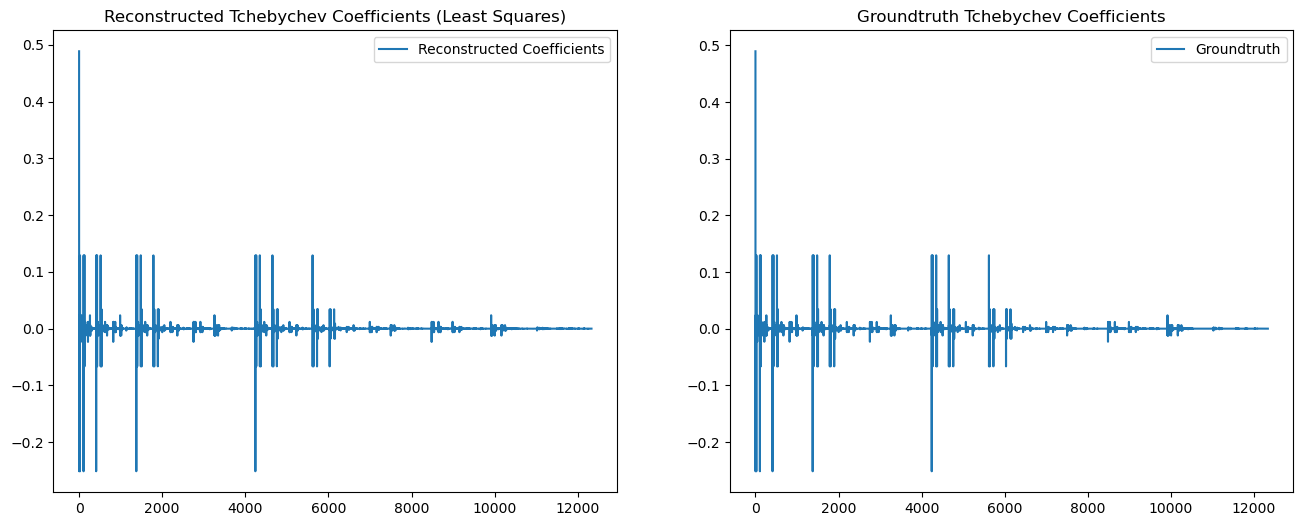

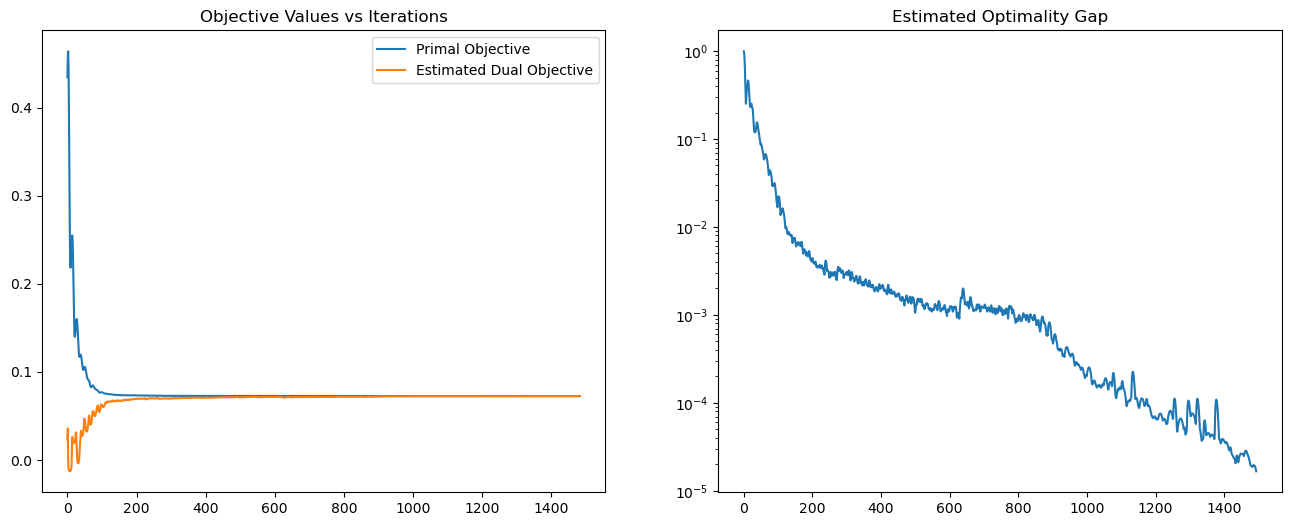

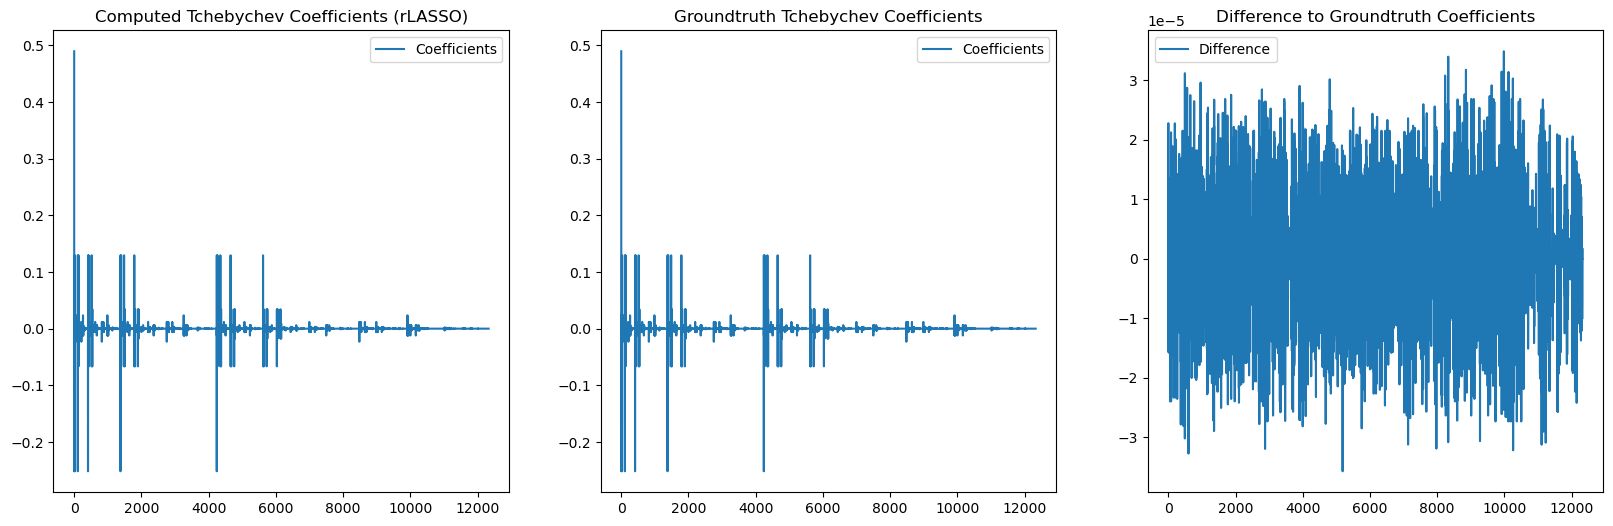

In [3]:
# run prim dual algorithm with restarts
start = time.time()

# Here we generate the data
indices, samples, values, coeffs_gt, trunc_error = generate_data(
    15_000, 20, 6, device=device_id, dtype=dtype
)

coeffs_rec, vals, vals_dual, coeffs_lsr_rec, residuals = (
    SQ_LASSO.Reconstruction_Tchebychev(
        samples, values, indices, lstsq_rec=True, tol=2e-6, restarts=11,
    )
)

# some evaluation metrics (rLASSO)
print("Time to compute rLASSO solution is", time.time() - start, "seconds")
print("Final residual of rLASSO solution is", residuals[0].item())
print(
    "Relative reconstruction error of rLASSO solution:",
    (trunc_error + torch.linalg.norm(coeffs_gt - coeffs_rec)).item(),
)
print(
    "Number of nonzero entries of rLASSO solution (with tolerance 1e-4):",
    torch.sum(torch.abs(coeffs_rec) > 1e-4).item(),
)

# evaluation of some metrics (Least Squares)
print("Residual of least squares solution is", residuals[1].item())
print(
    "Relative reconstruction error of least squares solution is",
    (trunc_error + torch.linalg.norm(coeffs_gt - coeffs_lsr_rec)).item(),
)

# Plot least squares coefficients
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(coeffs_lsr_rec.cpu(), label="Reconstructed Coefficients")
plt.legend()
plt.title("Reconstructed Tchebychev Coefficients (Least Squares)")

plt.subplot(1, 2, 2)
plt.plot(coeffs_gt.cpu(), label="Groundtruth")
plt.legend()
plt.title("Groundtruth Tchebychev Coefficients")

# Plot objective values
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(torch.tensor(vals[10:], device="cpu"), label="Primal Objective")
plt.plot(
    torch.tensor(vals_dual[10:], device="cpu"),
    label="Estimated Dual Objective",
)
plt.legend()
plt.title("Objective Values vs Iterations")

plt.subplot(1, 2, 2)
plt.plot(
    torch.tensor(vals, device="cpu")
    - torch.tensor(vals_dual, device="cpu")
)
plt.yscale("log")
plt.title("Estimated Optimality Gap")

# Plot rLASSO vs ground truth
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(coeffs_rec.cpu(), label="Coefficients")
plt.legend()
plt.title("Computed Tchebychev Coefficients (rLASSO)")

plt.subplot(1, 3, 2)
plt.plot(coeffs_gt.cpu(), label="Coefficients")
plt.legend()
plt.title("Groundtruth Tchebychev Coefficients")

plt.subplot(1, 3, 3)
plt.plot(coeffs_rec.cpu() - coeffs_gt.cpu(), label="Difference")
plt.legend()
plt.title("Difference to Groundtruth Coefficients")

In [4]:
print(vals[-1] - vals_dual[-1])

1.6689300537109375e-05
